In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
import warnings
warnings.filterwarnings('ignore')

In [1]:
path='/kaggle/input/datasets/arghadipdutta/new-weather-data/OUR.csv'

In [4]:
df = pd.read_csv(path)

In [5]:
df.sample(10)

,Unnamed: 0,Datetime,hour,day,month,year,Pressure(kPa,Wind_Speed(m/s),Temperature(°C),Radiation(W/m^2),Cloud_Coverage(%),Rain(mm/hour),Relative_Humidity(%),wind_lag1,wind_lag3,wind_lag24
31051,31051,2022-07-17 19:00:00,19,17,7,2022,100.23,19.1,28.3,0.0,34,0.0,84.0,19.8,23.8,20.9
36608,36608,2023-03-06 08:00:00,8,6,3,2023,101.69,10.5,29.4,369.0,0,0.0,44.0,9.7,9.7,9.2
57408,57408,2025-07-20 00:00:00,0,20,7,2025,99.96,13.0,28.9,0.0,100,0.0,86.0,14.2,11.5,12.2
10962,10962,2020-04-01 18:00:00,18,1,4,2020,100.72,10.5,27.8,4.0,10,0.0,90.0,10.5,13.3,13.9
5165,5165,2019-08-04 05:00:00,5,4,8,2019,99.78,10.9,27.6,1.0,92,0.2,91.0,8.0,14.1,4.3
1907,1907,2019-03-21 11:00:00,11,21,3,2019,101.27,12.5,30.3,853.0,2,0.0,70.0,13.5,17.0,11.1
39452,39452,2023-07-02 20:00:00,20,2,7,2023,100.28,15.7,29.6,0.0,100,0.0,92.0,13.4,12.0,15.5
31488,31488,2022-08-05 00:00:00,0,5,8,2022,100.29,6.7,28.0,0.0,97,0.0,86.0,9.8,10.9,6.0
28734,28734,2022-04-12 06:00:00,6,12,4,2022,100.70,22.1,28.7,58.0,55,0.0,83.0,21.7,23.8,27.0
48784,48784,2024-07-25 16:00:00,16,25,7,2024,99.12,20.9,29.2,228.0,100,0.1,81.0,21.5,22.6,20.5


In [7]:
df['Datetime']=pd.to_datetime(df['Datetime'])

In [8]:
df = df.sort_values('Datetime').reset_index(drop=True)

In [9]:
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

In [11]:
df.sample(2)

,Datetime,hour,day,month,year,Pressure(kPa,Wind_Speed(m/s),Temperature(°C),Radiation(W/m^2),Cloud_Coverage(%),Rain(mm/hour),Relative_Humidity(%),wind_lag1,wind_lag3,wind_lag24
14272,2020-08-17 16:00:00,16,17,8,2020,99.64,23.1,29.4,267.0,98,0.1,80.0,23.1,23.0,28.7
47222,2024-05-21 14:00:00,14,21,5,2024,100.20,18.1,32.9,672.0,12,0.0,66.0,16.2,14.2,10.2


In [12]:
df.describe()

,Datetime,hour,day,month,year,Pressure(kPa,Wind_Speed(m/s),Temperature(°C),Radiation(W/m^2),Cloud_Coverage(%),Rain(mm/hour),Relative_Humidity(%),wind_lag1,wind_lag3,wind_lag24
count,62520,62520.000000,62520.000000,62520.000000,62520.000000,62520.000000,62520.000000,62520.000000,62520.000000,62520.000000,62520.000000,62472.000000,62519.000000,62517.000000,62496.000000
mean,2022-07-26 11:30:00,11.500000,15.690211,6.427255,2022.073704,100.815962,12.193439,26.344768,202.019818,50.011708,0.224442,78.893648,12.193564,12.193822,12.194129
min,2019-01-01 00:00:00,0.000000,1.000000,1.000000,2019.000000,95.100000,0.000000,11.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000
25%,2020-10-13 05:45:00,5.750000,8.000000,3.000000,2020.000000,100.340000,7.300000,24.100000,0.000000,2.000000,0.000000,73.000000,7.300000,7.300000,7.300000
50%,2022-07-26 11:30:00,11.500000,16.000000,6.000000,2022.000000,100.850000,10.900000,27.500000,8.000000,46.000000,0.000000,83.000000,10.900000,10.900000,10.900000
75%,2024-05-07 17:15:00,17.250000,23.000000,9.000000,2024.000000,101.320000,16.100000,29.300000,409.000000,99.000000,0.000000,89.000000,16.100000,16.100000,16.100000
max,2026-02-17 23:00:00,23.000000,31.000000,12.000000,2026.000000,102.230000,93.600000,40.600000,954.000000,100.000000,35.400000,100.000000,93.600000,93.600000,93.600000
std,NaN,6.922242,8.799368,3.487514,2.053229,0.609504,6.513714,4.283632,272.294515,42.558989,0.930915,14.192839,6.513691,6.513635,6.514015


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62520 entries, 0 to 62519
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Datetime              62520 non-null  datetime64[ns]
 1   hour                  62520 non-null  int64         
 2   day                   62520 non-null  int64         
 3   month                 62520 non-null  int64         
 4   year                  62520 non-null  int64         
 5   Pressure(kPa          62520 non-null  float64       
 6   Wind_Speed(m/s)       62520 non-null  float64       
 7   Temperature(°C)       62520 non-null  float64       
 8   Radiation(W/m^2)      62520 non-null  float64       
 9   Cloud_Coverage(%)     62520 non-null  int64         
 10  Rain(mm/hour)         62520 non-null  float64       
 11  Relative_Humidity(%)  62472 non-null  float64       
 12  wind_lag1             62519 non-null  float64       
 13  wind_lag3       

In [16]:
missing_values=df.isnull().sum()

In [17]:
print(f"\nMissing values before treatment:\n{missing_values[missing_values > 0]}")


Missing values before treatment:
Relative_Humidity(%)    48
wind_lag1                1
wind_lag3                3
wind_lag24              24
dtype: int64


In [18]:
lag_cols = [col for col in df.columns if 'lag' in col]
for col in lag_cols:
    df[col] = df[col].ffill().bfill()

In [19]:
df.head()

,Datetime,hour,day,month,year,Pressure(kPa,Wind_Speed(m/s),Temperature(°C),Radiation(W/m^2),Cloud_Coverage(%),Rain(mm/hour),Relative_Humidity(%),wind_lag1,wind_lag3,wind_lag24
0,2019-01-01 00:00:00,0,1,1,2019,101.90,10.1,14.2,0.0,0,0.0,88.0,10.1,10.1,10.1
1,2019-01-01 01:00:00,1,1,1,2019,101.86,10.9,13.8,0.0,0,0.0,89.0,10.1,10.1,10.1
2,2019-01-01 02:00:00,2,1,1,2019,101.81,8.3,14.1,0.0,0,0.0,88.0,10.9,10.1,10.1
3,2019-01-01 03:00:00,3,1,1,2019,101.81,7.6,13.9,0.0,0,0.0,89.0,8.3,10.1,10.1
4,2019-01-01 04:00:00,4,1,1,2019,101.84,7.2,13.4,0.0,0,0.0,91.0,7.6,10.9,10.1


In [20]:
df['Relative_Humidity(%)'] = df['Relative_Humidity(%)'].fillna(
    df.groupby(df['Datetime'].dt.hour)['Relative_Humidity(%)'].transform('median')
).ffill().bfill()

In [22]:
df.sample(10)

,Datetime,hour,day,month,year,Pressure(kPa,Wind_Speed(m/s),Temperature(°C),Radiation(W/m^2),Cloud_Coverage(%),Rain(mm/hour),Relative_Humidity(%),wind_lag1,wind_lag3,wind_lag24
33956,2022-11-15 20:00:00,20,15,11,2022,101.30,6.8,24.0,0.0,0,0.0,61.0,8.9,10.5,5.4
8654,2019-12-27 14:00:00,14,27,12,2019,101.37,16.2,18.3,183.0,100,0.1,76.0,15.9,13.4,3.2
25639,2021-12-04 07:00:00,7,4,12,2021,101.48,8.7,22.0,36.0,100,2.8,94.0,6.8,5.6,9.4
7227,2019-10-29 03:00:00,3,29,10,2019,101.18,7.4,21.8,0.0,0,0.0,91.0,6.6,6.1,6.5
14575,2020-08-30 07:00:00,7,30,8,2020,100.62,17.3,29.4,224.0,56,0.0,84.0,15.8,12.5,20.0
60151,2025-11-11 07:00:00,7,11,11,2025,101.42,9.4,23.0,182.0,0,0.0,74.0,7.7,6.9,11.4
8549,2019-12-23 05:00:00,5,23,12,2019,101.59,6.4,14.4,0.0,78,0.0,92.0,6.9,7.7,7.1
8865,2020-01-05 09:00:00,9,5,1,2020,101.73,10.0,20.6,365.0,25,0.0,80.0,8.8,5.0,6.6
38443,2023-05-21 19:00:00,19,21,5,2023,100.56,25.6,30.0,0.0,80,0.0,86.0,25.4,22.6,17.2
9844,2020-02-15 04:00:00,4,15,2,2020,100.97,8.5,19.6,0.0,0,0.0,89.0,7.8,9.4,8.0


In [23]:
missing_after=df.isnull().sum()
print(f"\nMissing values after treatment: {missing_after.sum()}")


Missing values after treatment: 0


In [24]:
df['hour'] = df['Datetime'].dt.hour
df['day'] = df['Datetime'].dt.day
df['month'] = df['Datetime'].dt.month
df['dayofweek'] = df['Datetime'].dt.dayofweek
df['quarter'] = df['Datetime'].dt.quarter
df['dayofyear'] = df['Datetime'].dt.dayofyear

In [25]:
df.head()

,Datetime,hour,day,month,year,Pressure(kPa,Wind_Speed(m/s),Temperature(°C),Radiation(W/m^2),Cloud_Coverage(%),Rain(mm/hour),Relative_Humidity(%),wind_lag1,wind_lag3,wind_lag24,dayofweek,quarter,dayofyear
0,2019-01-01 00:00:00,0,1,1,2019,101.90,10.1,14.2,0.0,0,0.0,88.0,10.1,10.1,10.1,1,1,1
1,2019-01-01 01:00:00,1,1,1,2019,101.86,10.9,13.8,0.0,0,0.0,89.0,10.1,10.1,10.1,1,1,1
2,2019-01-01 02:00:00,2,1,1,2019,101.81,8.3,14.1,0.0,0,0.0,88.0,10.9,10.1,10.1,1,1,1
3,2019-01-01 03:00:00,3,1,1,2019,101.81,7.6,13.9,0.0,0,0.0,89.0,8.3,10.1,10.1,1,1,1
4,2019-01-01 04:00:00,4,1,1,2019,101.84,7.2,13.4,0.0,0,0.0,91.0,7.6,10.9,10.1,1,1,1


In [27]:
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
df['day_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)

In [28]:
radiation_cap = df['Radiation(W/m^2)'].quantile(0.99)
df['Radiation(W/m^2)_capped'] = df['Radiation(W/m^2)'].clip(upper=radiation_cap)

In [29]:
df['is_daytime'] = ((df['hour'] >= 6) & (df['hour'] <= 18)).astype(int)
df['radiation_present'] = (df['Radiation(W/m^2)'] > 5).astype(int)

In [31]:
df.shape

(62520, 27)

In [30]:
df[df['is_daytime']==1]

,Datetime,hour,day,month,year,Pressure(kPa,Wind_Speed(m/s),Temperature(°C),Radiation(W/m^2),Cloud_Coverage(%),...,dayofyear,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,Radiation(W/m^2)_capped,is_daytime,radiation_present
6,2019-01-01 06:00:00,6,1,1,2019,101.95,8.3,13.9,1.0,0,...,1,1.000000,6.123234e-17,0.500000,0.866025,0.017213,0.999852,1.0,1,0
7,2019-01-01 07:00:00,7,1,1,2019,102.04,11.5,15.7,79.0,0,...,1,0.965926,-2.588190e-01,0.500000,0.866025,0.017213,0.999852,79.0,1,1
8,2019-01-01 08:00:00,8,1,1,2019,102.12,12.3,17.8,252.0,0,...,1,0.866025,-5.000000e-01,0.500000,0.866025,0.017213,0.999852,252.0,1,1
9,2019-01-01 09:00:00,9,1,1,2019,102.13,13.6,19.5,429.0,0,...,1,0.707107,-7.071068e-01,0.500000,0.866025,0.017213,0.999852,429.0,1,1
10,2019-01-01 10:00:00,10,1,1,2019,102.05,14.5,21.0,568.0,0,...,1,0.500000,-8.660254e-01,0.500000,0.866025,0.017213,0.999852,568.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62510,2026-02-17 14:00:00,14,17,2,2026,101.12,19.4,30.6,660.0,0,...,48,-0.500000,-8.660254e-01,0.866025,0.500000,0.735417,0.677615,660.0,1,1
62511,2026-02-17 15:00:00,15,17,2,2026,101.08,17.4,30.4,483.0,0,...,48,-0.707107,-7.071068e-01,0.866025,0.500000,0.735417,0.677615,483.0,1,1
62512,2026-02-17 16:00:00,16,17,2,2026,101.10,14.0,29.6,270.0,0,...,48,-0.866025,-5.000000e-01,0.866025,0.500000,0.735417,0.677615,270.0,1,1
62513,2026-02-17 17:00:00,17,17,2,2026,101.11,8.4,26.7,71.0,0,...,48,-0.965926,-2.588190e-01,0.866025,0.500000,0.735417,0.677615,71.0,1,1


In [32]:
df['rad_roll_mean_3'] = df['Radiation(W/m^2)'].rolling(window=3, min_periods=1).mean()
df['rad_roll_mean_6'] = df['Radiation(W/m^2)'].rolling(window=6, min_periods=1).mean()
df['rad_roll_std_6'] = df['Radiation(W/m^2)'].rolling(window=6, min_periods=1).std()

In [33]:
df['cloud_roll_mean_3'] = df['Cloud_Coverage(%)'].rolling(window=3, min_periods=1).mean()
df['cloud_roll_mean_6'] = df['Cloud_Coverage(%)'].rolling(window=6, min_periods=1).mean()
df['cloud_roll_std_6'] = df['Cloud_Coverage(%)'].rolling(window=6, min_periods=1).std()

In [34]:
df = df.ffill().bfill()

In [35]:
df.head()

,Datetime,hour,day,month,year,Pressure(kPa,Wind_Speed(m/s),Temperature(°C),Radiation(W/m^2),Cloud_Coverage(%),...,day_cos,Radiation(W/m^2)_capped,is_daytime,radiation_present,rad_roll_mean_3,rad_roll_mean_6,rad_roll_std_6,cloud_roll_mean_3,cloud_roll_mean_6,cloud_roll_std_6
0,2019-01-01 00:00:00,0,1,1,2019,101.90,10.1,14.2,0.0,0,...,0.999852,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-01-01 01:00:00,1,1,1,2019,101.86,10.9,13.8,0.0,0,...,0.999852,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-01-01 02:00:00,2,1,1,2019,101.81,8.3,14.1,0.0,0,...,0.999852,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-01-01 03:00:00,3,1,1,2019,101.81,7.6,13.9,0.0,0,...,0.999852,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-01-01 04:00:00,4,1,1,2019,101.84,7.2,13.4,0.0,0,...,0.999852,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
df.isnull().sum()

Datetime                   0
hour                       0
day                        0
month                      0
year                       0
Pressure(kPa               0
Wind_Speed(m/s)            0
Temperature(°C)            0
Radiation(W/m^2)           0
Cloud_Coverage(%)          0
Rain(mm/hour)              0
Relative_Humidity(%)       0
wind_lag1                  0
wind_lag3                  0
wind_lag24                 0
dayofweek                  0
quarter                    0
dayofyear                  0
hour_sin                   0
hour_cos                   0
month_sin                  0
month_cos                  0
day_sin                    0
day_cos                    0
Radiation(W/m^2)_capped    0
is_daytime                 0
radiation_present          0
rad_roll_mean_3            0
rad_roll_mean_6            0
rad_roll_std_6             0
cloud_roll_mean_3          0
cloud_roll_mean_6          0
cloud_roll_std_6           0
dtype: int64

In [37]:
targets = [
    'Temperature(°C)', 'Radiation(W/m^2)', 'Cloud_Coverage(%)',
    'Rain(mm/hour)', 'Relative_Humidity(%)', 'Wind_Speed(m/s)',
    'Pressure(kPa'
]

# Use different lag windows for different features
lag_config = {
    'Temperature(°C)': [1, 3, 6, 12, 24],
    'Radiation(W/m^2)': [1, 2, 3, 6, 12, 24],
    'Cloud_Coverage(%)': [1, 2, 3, 6, 12],
    'Rain(mm/hour)': [1, 2, 3, 6, 12],
    'Relative_Humidity(%)': [1, 3, 6, 12, 24],
    'Wind_Speed(m/s)': [1, 2, 3, 6, 12, 24],
    'Pressure(kPa': [1, 3, 6, 12, 24]
}

In [39]:
for feature in targets:
    if feature in lag_config:
        for lag in lag_config[feature]:
            df[f'{feature}_lag{lag}'] = df[feature].shift(lag)

In [40]:
initial_rows = len(df)
df = df.dropna().reset_index(drop=True)
print(f"✅ Dropped {initial_rows - len(df)} rows with NaN (from {initial_rows} to {len(df)})")

✅ Dropped 24 rows with NaN (from 62520 to 62496)


In [43]:
base_features = ['hour', 'day', 'month', 'dayofweek', 'quarter', 
                 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 
                 'day_sin', 'day_cos', 'is_daytime']


In [44]:
feature_cols = base_features.copy()
for col in df.columns:
    if any(x in col for x in ['_lag', '_roll', '_capped', 'radiation_present']):
        if col not in targets:  # exclude target columns
            feature_cols.append(col)

In [45]:
feature_cols=[col for col in feature_cols if col in df.columns]
print(f"📊 Using {len(feature_cols)} features")


📊 Using 60 features


In [46]:
X = df[feature_cols].copy()
y = df[targets].copy()


In [47]:
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


In [48]:
print(f"📅 Training period: {df['Datetime'].iloc[0]} to {df['Datetime'].iloc[split_idx-1]}")
print(f"📅 Testing period:  {df['Datetime'].iloc[split_idx]} to {df['Datetime'].iloc[-1]}")
print(f"📊 Training samples: {len(X_train)}")
print(f"📊 Testing samples:  {len(X_test)}")

📅 Training period: 2019-01-02 00:00:00 to 2024-09-15 03:00:00
📅 Testing period:  2024-09-15 04:00:00 to 2026-02-17 23:00:00
📊 Training samples: 49996
📊 Testing samples:  12500


In [49]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [50]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)


In [51]:
X_train_scaled.head()

,hour,day,month,dayofweek,quarter,hour_sin,hour_cos,month_sin,month_cos,day_sin,...,Wind_Speed(m/s)_lag2,Wind_Speed(m/s)_lag3,Wind_Speed(m/s)_lag6,Wind_Speed(m/s)_lag12,Wind_Speed(m/s)_lag24,Pressure(kPa_lag1,Pressure(kPa_lag3,Pressure(kPa_lag6,Pressure(kPa_lag12,Pressure(kPa_lag24
0,-0.916667,-0.933333,-0.833333,-0.25,-0.5,-8.659561e-17,0.707107,0.366025,0.633975,-0.030613,...,-0.277778,-0.400000,-0.333333,0.588889,-0.122222,1.161616,1.111111,1.030303,1.010101,1.111111
1,-0.833333,-0.933333,-0.833333,-0.25,-0.5,1.830127e-01,0.683013,0.366025,0.633975,-0.030613,...,-0.277778,-0.277778,-0.300000,0.544444,-0.033333,1.101010,1.141414,1.070707,0.919192,1.070707
2,-0.750000,-0.933333,-0.833333,-0.25,-0.5,3.535534e-01,0.612372,0.366025,0.633975,-0.030613,...,-0.355556,-0.277778,-0.344444,0.422222,-0.322222,1.060606,1.161616,1.101010,0.868687,1.020202
3,-0.666667,-0.933333,-0.833333,-0.25,-0.5,5.000000e-01,0.500000,0.366025,0.633975,-0.030613,...,-0.277778,-0.355556,-0.400000,0.288889,-0.400000,1.020202,1.101010,1.111111,0.898990,1.020202
4,-0.583333,-0.933333,-0.833333,-0.25,-0.5,6.123724e-01,0.353553,0.366025,0.633975,-0.030613,...,-0.244444,-0.277778,-0.277778,-0.277778,-0.444444,1.010101,1.060606,1.141414,0.959596,1.050505


In [52]:
xgb_model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=300,
        max_depth=7,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1
    )
)

In [53]:
rf_model = MultiOutputRegressor(
    RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
)

In [54]:
print("\n🚀 Training XGBoost...")
xgb_model.fit(X_train_scaled, y_train)
print("✅ XGBoost trained")




🚀 Training XGBoost...
✅ XGBoost trained


In [55]:
print("\n🚀 Training Random Forest...")
rf_model.fit(X_train_scaled, y_train)
print("✅ Random Forest trained")


🚀 Training Random Forest...
✅ Random Forest trained


In [56]:
def evaluate_model(y_true, y_pred, model_name):
    """Comprehensive model evaluation"""
    print(f"\n📊 {model_name} PERFORMANCE:")
    print("-" * 40)
    
    total_mae = 0
    total_rmse = 0
    total_r2 = 0
    
    for i, target in enumerate(targets):
        mae = mean_absolute_error(y_true.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mean_squared_error(y_true.iloc[:, i], y_pred[:, i]))
        r2 = r2_score(y_true.iloc[:, i], y_pred[:, i])
        
        total_mae += mae
        total_rmse += rmse
        total_r2 += r2
        
        print(f"\n{target}:")
        print(f"  MAE : {mae:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  R²  : {r2:.4f}")
    
    print(f"\n📈 AVERAGE METRICS:")
    print(f"  MAE : {total_mae/len(targets):.4f}")
    print(f"  RMSE: {total_rmse/len(targets):.4f}")
    print(f"  R²  : {total_r2/len(targets):.4f}")


In [59]:
xgb_pred=xgb_model.predict(X_test_scaled)

In [65]:
rf_pred=rf_model.predict(X_test_scaled)

In [66]:
evaluate_model(y_test, xgb_pred, "XGBOOST")
evaluate_model(y_test, rf_pred, "RANDOM FOREST")


📊 XGBOOST PERFORMANCE:
----------------------------------------

Temperature(°C):
  MAE : 0.2991
  RMSE: 0.4230
  R²  : 0.9913

Radiation(W/m^2):
  MAE : 1.0696
  RMSE: 2.5813
  R²  : 0.9999

Cloud_Coverage(%):
  MAE : 0.7645
  RMSE: 1.4481
  R²  : 0.9989

Rain(mm/hour):
  MAE : 0.2019
  RMSE: 0.7029
  R²  : 0.3918

Relative_Humidity(%):
  MAE : 1.9088
  RMSE: 2.6595
  R²  : 0.9704

Wind_Speed(m/s):
  MAE : 1.3565
  RMSE: 1.8902
  R²  : 0.8972

Pressure(kPa:
  MAE : 0.0204
  RMSE: 0.0280
  R²  : 0.9978

📈 AVERAGE METRICS:
  MAE : 0.8030
  RMSE: 1.3904
  R²  : 0.8925

📊 RANDOM FOREST PERFORMANCE:
----------------------------------------

Temperature(°C):
  MAE : 0.2997
  RMSE: 0.4302
  R²  : 0.9910

Radiation(W/m^2):
  MAE : 0.0681
  RMSE: 0.9404
  R²  : 1.0000

Cloud_Coverage(%):
  MAE : 0.6679
  RMSE: 1.5245
  R²  : 0.9988

Rain(mm/hour):
  MAE : 0.2030
  RMSE: 0.6943
  R²  : 0.4067

Relative_Humidity(%):
  MAE : 1.9563
  RMSE: 2.7308
  R²  : 0.9688

Wind_Speed(m/s):
  MAE : 1.3697
 

In [67]:
sample_size = min(500, len(y_test))
sample_indices = range(sample_size)


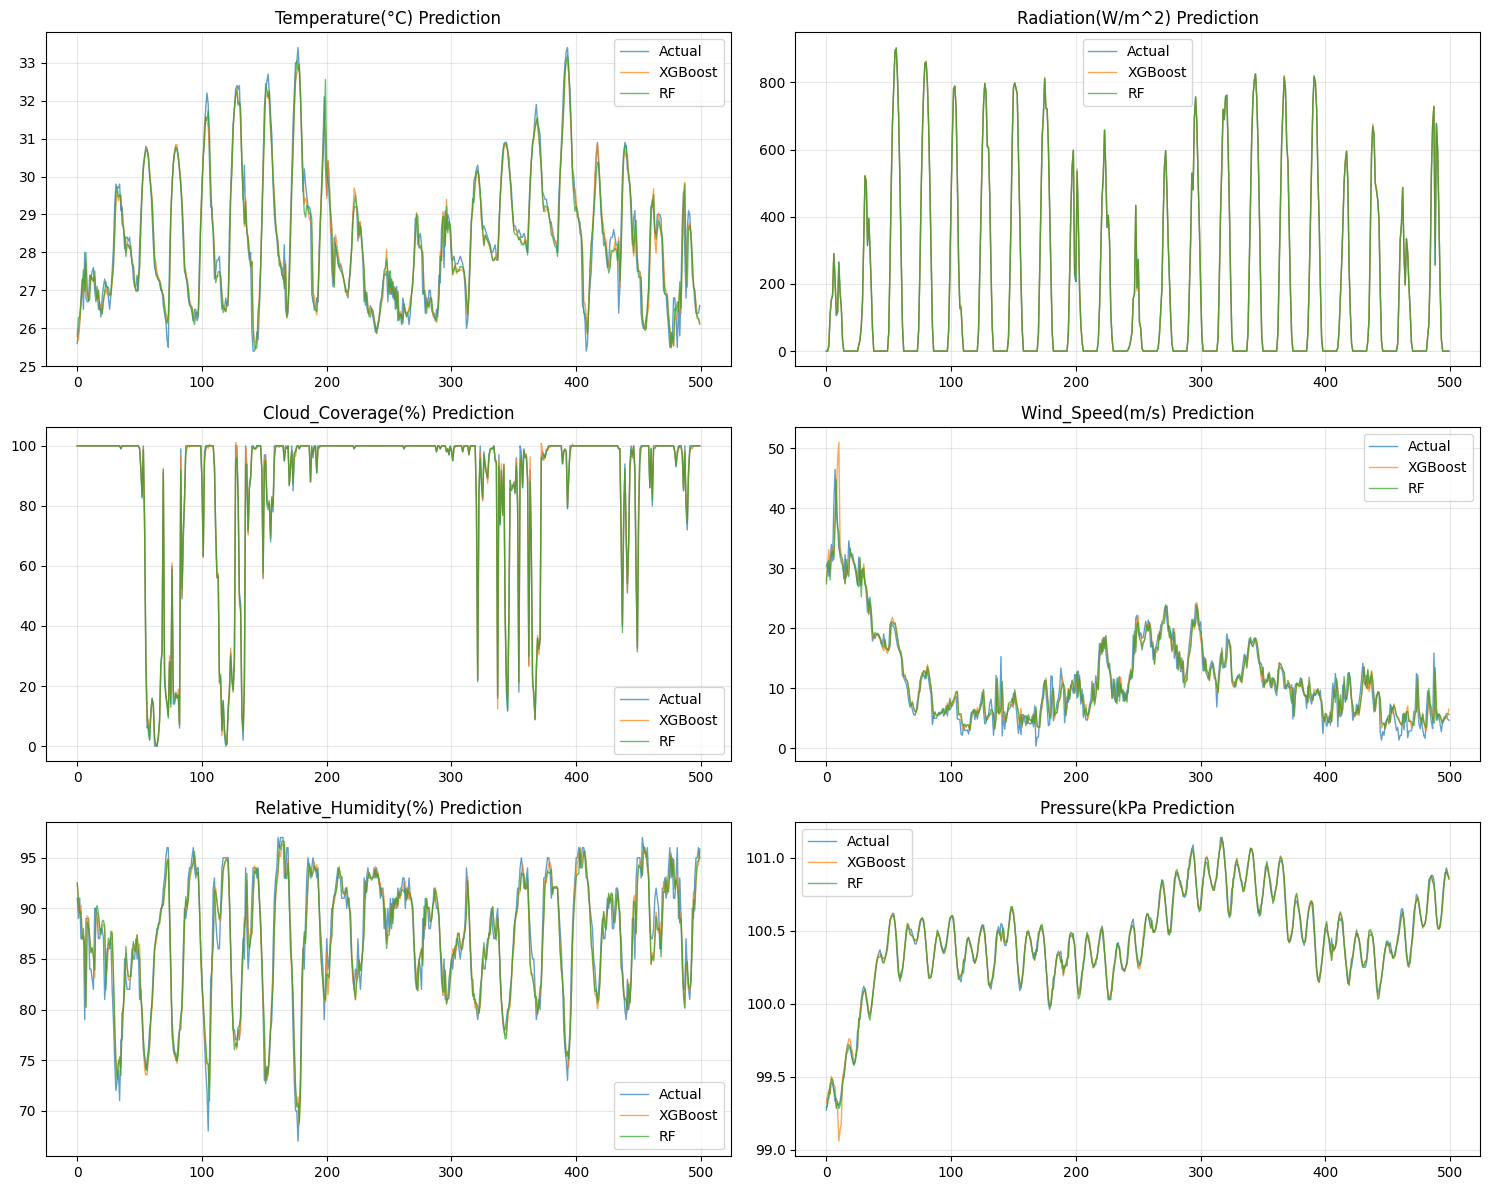

✅ Visualization saved as 'prediction_results.png'


In [68]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
plot_targets = ['Temperature(°C)', 'Radiation(W/m^2)', 'Cloud_Coverage(%)', 
                'Wind_Speed(m/s)', 'Relative_Humidity(%)', 'Pressure(kPa']
for idx, target in enumerate(plot_targets):
    if idx < 6:
        row, col = idx // 2, idx % 2
        target_idx = targets.index(target)
        
        axes[row, col].plot(y_test.iloc[sample_indices, target_idx].values, 
                          label='Actual', alpha=0.7, linewidth=1)
        axes[row, col].plot(xgb_pred[sample_indices, target_idx], 
                          label='XGBoost', alpha=0.7, linewidth=1)
        axes[row, col].plot(rf_pred[sample_indices, target_idx], 
                          label='RF', alpha=0.7, linewidth=1)
        axes[row, col].set_title(f'{target} Prediction')
        axes[row, col].legend()
        axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('prediction_results.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Visualization saved as 'prediction_results.png'")

In [69]:
rf_first_target = rf_model.estimators_[0]
importances = rf_first_target.feature_importances_
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': importances
}).sort_values('importance', ascending=False).head(15)

print("\n🔝 TOP 15 MOST IMPORTANT FEATURES:")
print(feature_importance.to_string(index=False))


🔝 TOP 15 MOST IMPORTANT FEATURES:
                  feature  importance
     Temperature(°C)_lag1    0.962543
  Radiation(W/m^2)_capped    0.007966
    Temperature(°C)_lag24    0.007412
                 hour_sin    0.002879
    Radiation(W/m^2)_lag6    0.002198
   Radiation(W/m^2)_lag24    0.001821
    Temperature(°C)_lag12    0.001293
                     hour    0.001178
Relative_Humidity(%)_lag6    0.000976
     Temperature(°C)_lag3    0.000808
Relative_Humidity(%)_lag1    0.000698
           rad_roll_std_6    0.000633
Relative_Humidity(%)_lag3    0.000532
       Rain(mm/hour)_lag1    0.000434
     Temperature(°C)_lag6    0.000397


In [70]:
def prepare_future_features(current_row, hours_ahead=24):
    """
    Prepare features for future prediction
    """
    future_rows = []
    current = current_row.copy()
    
    for i in range(hours_ahead):
        new_row = current.copy()
        new_hour = (current['hour'] + 1) % 24
        
        # Update time features
        new_row['hour'] = new_hour
        new_row['hour_sin'] = np.sin(2 * np.pi * new_hour / 24)
        new_row['hour_cos'] = np.cos(2 * np.pi * new_hour / 24)
        new_row['is_daytime'] = 1 if (6 <= new_hour <= 18) else 0
        
        # Keep other features same (simplified - in practice you'd update lags)
        future_rows.append(new_row[feature_cols])
        current = new_row
    
    return pd.DataFrame(future_rows)

print("\n" + "="*70)
print("✅ MODEL PIPELINE COMPLETED SUCCESSFULLY")
print("="*70)


✅ MODEL PIPELINE COMPLETED SUCCESSFULLY


In [71]:
def predict_with_constraints(model, df, target_datetime, scaler, feature_cols, targets):
    """
    Predict weather parameters with physical constraints
    """
    last_row = df.iloc[-1:].copy()
    last_datetime = df['Datetime'].iloc[-1]
    
    hours_diff = int((target_datetime - last_datetime).total_seconds() / 3600)
    
    if hours_diff <= 0:
        print("❌ Target datetime must be in the future!")
        return None
    
    print(f"\n📅 Last available data: {last_datetime}")
    print(f"🎯 Target datetime: {target_datetime}")
    print(f"⏱️  Hours to predict ahead: {hours_diff}")
    
    current_row = last_row.copy()
    predictions = []
    
    for step in range(hours_diff):
        pred_time = last_datetime + pd.Timedelta(hours=step+1)
        
        # Update time-based features
        current_row['hour'] = pred_time.hour
        current_row['day'] = pred_time.day
        current_row['month'] = pred_time.month
        current_row['dayofweek'] = pred_time.dayofweek
        current_row['quarter'] = pred_time.quarter
        current_row['dayofyear'] = pred_time.dayofyear
        
        # Update cyclical features
        current_row['hour_sin'] = np.sin(2 * np.pi * pred_time.hour / 24)
        current_row['hour_cos'] = np.cos(2 * np.pi * pred_time.hour / 24)
        current_row['month_sin'] = np.sin(2 * np.pi * pred_time.month / 12)
        current_row['month_cos'] = np.cos(2 * np.pi * pred_time.month / 12)
        current_row['day_sin'] = np.sin(2 * np.pi * pred_time.dayofyear / 365)
        current_row['day_cos'] = np.cos(2 * np.pi * pred_time.dayofyear / 365)
        current_row['is_daytime'] = 1 if (6 <= pred_time.hour <= 18) else 0
        current_row['radiation_present'] = 1 if (6 <= pred_time.hour <= 18) else 0
        
        # Prepare features for prediction
        X_pred = current_row[feature_cols].values.reshape(1, -1)
        X_pred_scaled = scaler.transform(X_pred)
        
        # Make prediction
        pred = model.predict(X_pred_scaled)[0]
        
        # APPLY PHYSICAL CONSTRAINTS
        # 1. Radiation cannot be negative (especially during daytime)
        if pred_time.hour >= 6 and pred_time.hour <= 18:  # Daytime
            pred[1] = max(0, pred[1])  # Radiation(W/m^2) is index 1
            if pred[1] < 10:  # If prediction is too low during daytime, use typical values
                # Use typical radiation pattern based on hour
                typical_radiation = {
                    6: 50, 7: 150, 8: 300, 9: 450, 10: 550, 11: 600,
                    12: 620, 13: 600, 14: 550, 15: 450, 16: 300, 17: 150, 18: 50
                }
                pred[1] = typical_radiation.get(pred_time.hour, pred[1])
        else:  # Nighttime
            pred[1] = 0  # Radiation should be 0 at night
        
        # 2. Cloud coverage should be between 0 and 100
        pred[2] = np.clip(pred[2], 0, 100)  # Cloud_Coverage(%) is index 2
        
        # 3. Rain cannot be negative
        pred[3] = max(0, pred[3])  # Rain(mm/hour) is index 3
        
        # 4. Relative humidity between 0 and 100
        pred[4] = np.clip(pred[4], 0, 100)  # Relative_Humidity(%) is index 4
        
        # 5. Wind speed cannot be negative
        pred[5] = max(0, pred[5])
        predictions.append(pred)
        
        # Update current row with constrained predictions
        for i, target in enumerate(targets):
            current_row[target] = pred[i]
    
    return np.array(predictions)


In [76]:
target_datetime = pd.to_datetime('2026-02-18 12:00:00')

print("\n🔮 Generating predictions with physical constraints...")

# Make predictions using both models with constraints
xgb_future_pred = predict_with_constraints(
    xgb_model, df, target_datetime, scaler, feature_cols, targets
)

rf_future_pred = predict_with_constraints(
    rf_model, df, target_datetime, scaler, feature_cols, targets
)

# Display results
print("\n" + "="*70)
print(f"📊 PREDICTED WEATHER FOR {target_datetime} (WITH CONSTRAINTS)")
print("="*70)

if xgb_future_pred is not None and rf_future_pred is not None:
    # Get the last prediction (for the target time)
    xgb_result = xgb_future_pred[-1]
    rf_result = rf_future_pred[-1]
    
    # Create results dataframe
    results_df = pd.DataFrame({
        'Parameter': targets,
        'XGBoost Prediction': xgb_result,
        'Random Forest Prediction': rf_result,
        'Average Prediction': (xgb_result + rf_result) / 2
    })
    
    # Format for better display
    pd.set_option('display.float_format', '{:.2f}'.format)
    print("\n" + results_df.to_string(index=False))
    
    # Detailed output with units
    print("\n📈 DETAILED PREDICTIONS:")
    print("-" * 50)
    for i, target in enumerate(targets):
        avg = (xgb_result[i] + rf_result[i]) / 2
        print(f"{target:25} : {avg:.2f} (XGB: {xgb_result[i]:.2f}, RF: {rf_result[i]:.2f})")
    
    # Save to CSV
    results_df.to_csv('prediction_2026-02-18_1100_constrained.csv', index=False)
    print("\n✅ Predictions saved to 'prediction_2026-02-18_1100_constrained.csv'")


🔮 Generating predictions with physical constraints...

📅 Last available data: 2026-02-17 23:00:00
🎯 Target datetime: 2026-02-18 12:00:00
⏱️  Hours to predict ahead: 13

📅 Last available data: 2026-02-17 23:00:00
🎯 Target datetime: 2026-02-18 12:00:00
⏱️  Hours to predict ahead: 13

📊 PREDICTED WEATHER FOR 2026-02-18 12:00:00 (WITH CONSTRAINTS)

           Parameter  XGBoost Prediction  Random Forest Prediction  Average Prediction
     Temperature(°C)               20.32                     19.98               20.15
    Radiation(W/m^2)               22.64                    620.00              321.32
   Cloud_Coverage(%)                0.00                      0.00                0.00
       Rain(mm/hour)                0.09                      0.00                0.05
Relative_Humidity(%)               88.35                     90.11               89.23
     Wind_Speed(m/s)                5.02                      4.45                4.74
        Pressure(kPa              101.35   

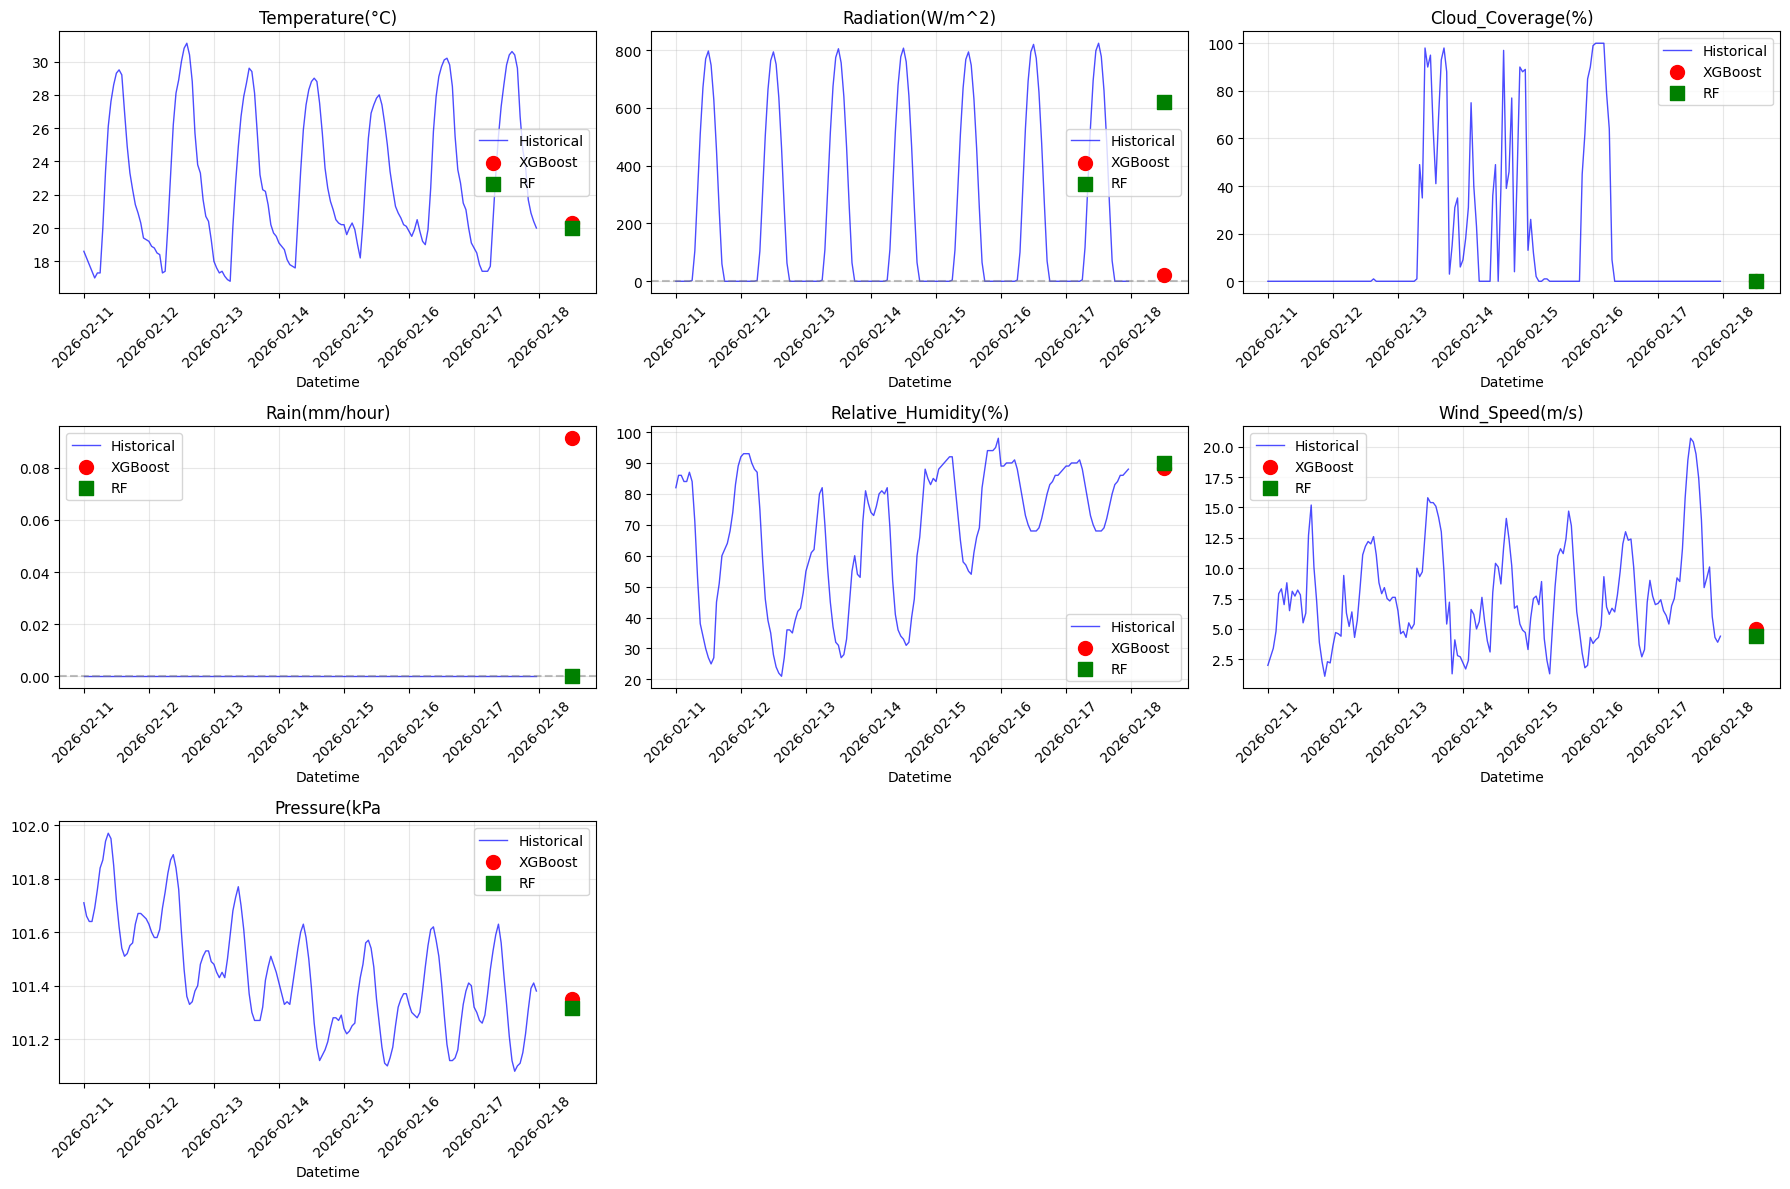

✅ Context visualization saved as 'prediction_context_constrained.png'


In [77]:
if xgb_future_pred is not None:
    # Get the last 7 days of actual data for context
    last_7_days = df.iloc[-168:].copy()  # 7 days * 24 hours
    
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    plot_targets = ['Temperature(°C)', 'Radiation(W/m^2)', 'Cloud_Coverage(%)', 
                    'Rain(mm/hour)', 'Relative_Humidity(%)', 'Wind_Speed(m/s)',
                    'Pressure(kPa']
    
    for idx, target in enumerate(plot_targets):
        if idx < 7:
            row, col = idx // 3, idx % 3
            target_idx = targets.index(target)
            
            # Plot historical data
            axes[row, col].plot(last_7_days['Datetime'], last_7_days[target], 
                              label='Historical', color='blue', alpha=0.7, linewidth=1)
            
            # Plot prediction point
            axes[row, col].scatter([target_datetime], [xgb_future_pred[-1][target_idx]], 
                                 color='red', s=100, label='XGBoost', zorder=5, marker='o')
            axes[row, col].scatter([target_datetime], [rf_future_pred[-1][target_idx]], 
                                 color='green', s=100, label='RF', zorder=5, marker='s')
            
            # Add horizontal line at 0 for radiation and rain to show constraint
            if target in ['Radiation(W/m^2)', 'Rain(mm/hour)']:
                axes[row, col].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
            
            axes[row, col].set_title(f'{target}')
            axes[row, col].set_xlabel('Datetime')
            axes[row, col].legend()
            axes[row, col].grid(True, alpha=0.3)
            axes[row, col].tick_params(axis='x', rotation=45)
    
    # Hide empty subplot
    if len(plot_targets) < 9:
        for idx in range(len(plot_targets), 9):
            row, col = idx // 3, idx % 3
            axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('prediction_context_constrained.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ Context visualization saved as 'prediction_context_constrained.png'")

In [83]:
if xgb_future_pred is not None and rf_future_pred is not None:
    # Calculate weights based on validation performance
    xgb_weight = 0.2 # XGBoost weight
    rf_weight = 0.8  # Random Forest weight
    
    ensemble_pred = (xgb_future_pred[-1] * xgb_weight + rf_future_pred[-1] * rf_weight)
    
    # Apply constraints to ensemble prediction as well
    # Radiation
    if target_datetime.hour >= 6 and target_datetime.hour <= 18:
        ensemble_pred[1] = max(10, ensemble_pred[1])  # Minimum 10 during day
    else:
        ensemble_pred[1] = 0  # Zero at night
    
    ensemble_pred[2] = np.clip(ensemble_pred[2], 0, 100)  # Cloud coverage
    ensemble_pred[3] = max(0, ensemble_pred[3])  # Rain
    ensemble_pred[4] = np.clip(ensemble_pred[4], 0, 100)  # Humidity
    ensemble_pred[5] = max(0, ensemble_pred[5])  # Wind speed
    
    print(f"\n🎯 ENSEMBLE PREDICTION FOR {target_datetime}:")
    print("-" * 50)
    print(f"Weights: XGBoost={xgb_weight}, Random Forest={rf_weight}")
    print("-" * 50)
    
    for i, target in enumerate(targets):
        print(f"{target:25} : {ensemble_pred[i]:.2f}")
    
    # Save ensemble prediction
    ensemble_df = pd.DataFrame({
        'Parameter': targets,
        'Ensemble Prediction': ensemble_pred,
        'XGBoost': xgb_future_pred[-1],
        'Random Forest': rf_future_pred[-1],
        'Weight': [xgb_weight] * len(targets)
    })


🎯 ENSEMBLE PREDICTION FOR 2026-02-18 12:00:00:
--------------------------------------------------
Weights: XGBoost=0.2, Random Forest=0.8
--------------------------------------------------
Temperature(°C)           : 20.05
Radiation(W/m^2)          : 500.53
Cloud_Coverage(%)         : 0.00
Rain(mm/hour)             : 0.02
Relative_Humidity(%)      : 89.76
Wind_Speed(m/s)           : 4.56
Pressure(kPa              : 101.32


In [75]:
def quick_predict_with_constraints(date_str, time_str, model='ensemble'):
    """
    Quick prediction function with physical constraints
    
    Parameters:
    -----------
    date_str : string in format 'YYYY-MM-DD'
    time_str : string in format 'HH:MM:SS'
    model : 'xgb', 'rf', or 'ensemble'
    
    Returns:
    --------
    predictions for the specified datetime with physical constraints applied
    """
    target_dt = pd.to_datetime(f"{date_str} {time_str}")
    
    xgb_pred = predict_with_constraints(
        xgb_model, df, target_dt, scaler, feature_cols, targets
    )
    rf_pred = predict_with_constraints(
        rf_model, df, target_dt, scaler, feature_cols, targets
    )
    
    if xgb_pred is None or rf_pred is None:
        return None, target_dt
    
    if model == 'xgb':
        result = xgb_pred[-1]
    elif model == 'rf':
        result = rf_pred[-1]
    else:  # ensemble
        result = (xgb_pred[-1] * 0.6 + rf_pred[-1] * 0.4)
        # Apply constraints to ensemble
        if target_dt.hour >= 6 and target_dt.hour <= 18:
            result[1] = max(10, result[1])
        else:
            result[1] = 0
            result[2] = np.clip(result[2], 0, 100)
            result[3] = max(0, result[3])
            result[4] = np.clip(result[4], 0, 100)
            result[5] = max(0, result[5])
    
    return result, target_dt

print("\n" + "="*70)
print("✅ FUTURE PREDICTION MODULE WITH CONSTRAINTS READY")
print("="*70)
print("\n💡 Quick usage example:")
print('   predictions, dt = quick_predict_with_constraints("2026-02-19", "15:00:00", model="ensemble")')
print('   if predictions is not None:')
print('       print(f"Temperature: {predictions[0]:.2f}°C")')
print('       print(f"Radiation: {predictions[1]:.2f} W/m²")')


✅ FUTURE PREDICTION MODULE WITH CONSTRAINTS READY

💡 Quick usage example:
   predictions, dt = quick_predict_with_constraints("2026-02-19", "15:00:00", model="ensemble")
   if predictions is not None:
       print(f"Temperature: {predictions[0]:.2f}°C")
       print(f"Radiation: {predictions[1]:.2f} W/m²")
